In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import sys

%matplotlib notebook

from run_utils import run_env_experiment, plot_ratings_mses

sys.path.append('../') 
from reclab.environments.latent_factors import DatasetLatentFactor, LatentFactorBehavior
from reclab.environments.topics import Topics

from reclab import data_utils


In [2]:
def get_dense_ratings(env):
    users, items, ratings = env.reset()
    rating_matrix = np.zeros([len(users), len(items)])
    for u in users.keys():
        for i in items.keys():
            rating_matrix[u,i] = env._get_rating(u, i)
    return rating_matrix

def plot_average_rating_hists(rating_matrix):
    average_item_ratings = np.nanmean(rating_matrix, axis=0)
    average_user_ratings = np.nanmean(rating_matrix, axis=1)
    
    def plot_hist(data, title):
        plt.hist(data, bins=np.linspace(0,5.5,12))
        plt.title(title)
        plt.xlim([-0.1,5.6])
        plt.xticks(np.linspace(0,5,6))
    
    plt.figure(figsize=[9,3])
    plt.subplot(1,3,1)
    plot_hist(average_item_ratings, "Average item Ratings")
    
    plt.subplot(1,3,2)
    plot_hist(average_user_ratings, "Average user Ratings")

    plt.subplot(1,3,3)
    all_ratings = rating_matrix.flatten()
    all_ratings = all_ratings[np.logical_not(np.isnan(all_ratings))]
    plot_hist(all_ratings, "All Ratings")
    plt.tight_layout()

In [3]:
num_users = 943
num_items = 1682

env_params = {
    'num_users': num_users,
    'num_items': num_items,
    'rating_frequency': 0.5,
    'num_init_ratings': 0
}


# ML-100K Model

In [4]:
params = {'latent_dim': 8}


env_params_dataset = {key:env_params[key] for key in env_params.keys() if key not in ['num_users', 'num_items']}
for key in ['num_users', 'num_items']:
    env_params_dataset['max_'+key] = env_params[key]
env = DatasetLatentFactor('ml-100k', **params, **env_params_dataset)


In [5]:
rating_matrix = get_dense_ratings(env)

Loading model from ../reclab/../data/ml-100k/fm_model.npz trained via:
{"num_user_features": 0, "num_item_features": 0, "num_rating_features": 0, "max_num_users": 1682, "max_num_items": 1682, "method": "sgd", "use_global_bias": true, "use_one_way": true, "num_two_way_factors": 8, "learning_rate": 0.005, "bias_reg": 0.1, "one_way_reg": 0.1, "two_way_reg": 0.1, "init_stdev": 0.1, "num_iter": 100, "seed": 0}.


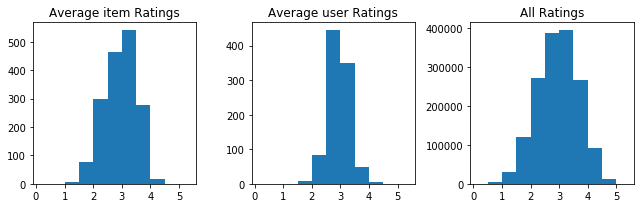

In [6]:
plot_average_rating_hists(rating_matrix)

# Smaller ML-100K Model

In [7]:
params = {'latent_dim': 8}

env_params_dataset = {key:env_params[key] for key in env_params.keys() if key not in ['num_users', 'num_items']}
env_params_dataset['max_num_users'] = env_params['num_users'] // 2
env_params_dataset['max_num_items'] = env_params['num_items']  // 2

env = DatasetLatentFactor('ml-100k', **params, **env_params_dataset)


In [8]:
rating_matrix = get_dense_ratings(env)

Loading model from ../reclab/../data/ml-100k/fm_model.npz trained via:
{"num_user_features": 0, "num_item_features": 0, "num_rating_features": 0, "max_num_users": 1682, "max_num_items": 1682, "method": "sgd", "use_global_bias": true, "use_one_way": true, "num_two_way_factors": 8, "learning_rate": 0.005, "bias_reg": 0.1, "one_way_reg": 0.1, "two_way_reg": 0.1, "init_stdev": 0.1, "num_iter": 100, "seed": 0}.


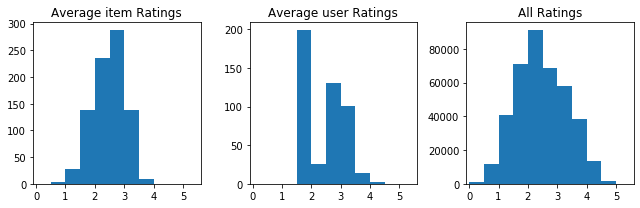

In [9]:
plot_average_rating_hists(rating_matrix)

# ML-100K Data

In [10]:
users, items, ratings = data_utils.read_dataset('ml-100k')
print(len(users), len(items))

943 1682


In [11]:
rating_matrix = np.nan * np.ones([len(users), len(items)])
for key in ratings.keys():
    u, i = key
    rating_matrix[u-1, i-1] = ratings[key][0]

In [12]:
average_item_ratings = np.nanmean(rating_matrix, axis=0)
average_user_ratings = np.nanmean(rating_matrix, axis=1)

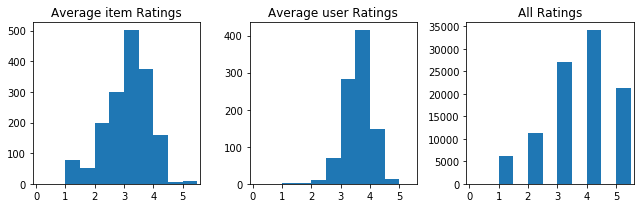

In [13]:
plot_average_rating_hists(rating_matrix)

# Random Latent Factor Model


In [14]:
params = {'latent_dim': 8}

env = LatentFactorBehavior(**params, **env_params)


In [15]:
rating_matrix = get_dense_ratings(env)

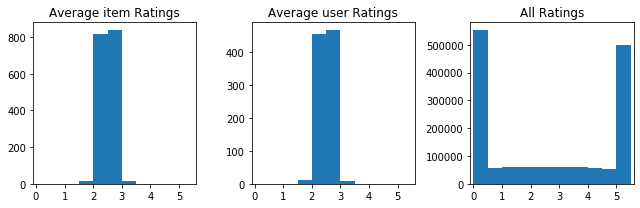

In [16]:
plot_average_rating_hists(rating_matrix)

# Random Topics Model

In [17]:
params = {'num_topics': 20}

env = Topics(**params, **env_params)


In [18]:
rating_matrix = get_dense_ratings(env)

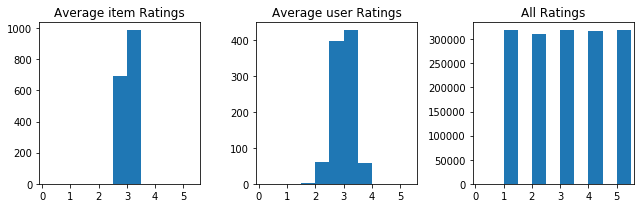

In [20]:
plot_average_rating_hists(rating_matrix)

In [21]:
np.max(rating_matrix)

5.0